<a href="https://colab.research.google.com/github/ATPONNUTTAYOTHIN781/Statistical-Learning-Labs/blob/main/Lab02_Data_Preprocessing_660510781.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# For Fashion-MNIST
from tensorflow.keras.datasets import fashion_mnist

# For 20 Newsgroups
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## Part 1: Marketing Campaign Dataset - Manual Data Preprocessing & Logistic Regression

### Load the Marketing Campaign Dataset ([Data Information](https://archive.ics.uci.edu/dataset/222/bank+marketing))

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be (`'yes'`) or not (`'no'`) subscribed.

In [2]:
bank_url = 'https://raw.githubusercontent.com/donlap/ds352-labs/main/bank.csv'

df = pd.read_csv(bank_url, sep=';', na_values=['unknown'])
df = df.drop(["emp.var.rate", "cons.price.idx", "cons.conf.idx",	"euribor3m", "nr.employed"], axis=1)
print("Shape of the dataset:", df.shape)
df.head()

Shape of the dataset: (41188, 16)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,no


### Data Exploration

In [3]:
print("--- Missing Values Count ---")
print(df.isnull().sum())

--- Missing Values Count ---
age               0
job             330
marital          80
education      1731
default        8597
housing         990
loan            990
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
y                 0
dtype: int64


In [4]:
print("--- Unique Values for Categorical Columns ---")
for col in df.select_dtypes(include='object').columns:
    print(f"\n'{col}' unique values:")
    print(df[col].value_counts(dropna=False)) # Include NaN counts

--- Unique Values for Categorical Columns ---

'job' unique values:
job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
NaN                330
Name: count, dtype: int64

'marital' unique values:
marital
married     24928
single      11568
divorced     4612
NaN            80
Name: count, dtype: int64

'education' unique values:
education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
NaN                     1731
illiterate                18
Name: count, dtype: int64

'default' unique values:
default
no     32588
NaN     8597
yes        3
Name: count, dtype: int64

'housing' unique values:
housing
yes    21576
no     18622
NaN      990
Name: count, dtype: int64


### Data Preprocessing

In [5]:
# Map target variable 'y' to 0 (no) and 1 (yes)
df['y'] = df['y'].map({'no': 0, 'yes': 1})

# Drop 'duration' due to data leakage
df = df.drop('duration', axis=1)

# Define features (X) and target (y)
X = df.drop('y', axis=1)
y = df['y']

# Split the data BEFORE any transformations
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Print data shape
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (32950, 14)
Test data shape: (8238, 14)


We will apply `StandardScaler()`, `OrdinalEncoder()`, and `OneHotEncoder()` on a few selected columns.

**1. Numerical Feature: `age` and `campaign` (Standard Scaling)**

In [6]:
num_cols_demo = ['age', 'campaign']

scaler = StandardScaler()

# Fit the scaler ONLY on the training data
scaler.fit(X_train[num_cols_demo])

# Transform train and test data
X_train_scaled_demo = scaler.transform(X_train[num_cols_demo])
X_test_scaled_demo = scaler.transform(X_test[num_cols_demo])

Let's take a look at the transformed `age` and `campaign` features and their statistics.

In [7]:
print("\nOriginal X_train 'age' and 'campaign' head:")
print(X_train[num_cols_demo].head())
print("\nScaled X_train 'age' and 'campaign' head:")
print(pd.DataFrame(X_train_scaled_demo, columns=num_cols_demo, index=X_train.index).head())

print("\nMean of scaled 'age' (train):", X_train_scaled_demo[:, 0].mean())
print("Std Dev of scaled 'campaign' (train):", X_train_scaled_demo[:, 1].std())


Original X_train 'age' and 'campaign' head:
       age  campaign
25611   49         4
26010   37         2
40194   78         1
297     36         2
36344   59         2

Scaled X_train 'age' and 'campaign' head:
            age  campaign
25611  0.863739  0.522981
26010 -0.289722 -0.203688
40194  3.651268 -0.567023
297   -0.385843 -0.203688
36344  1.824956 -0.203688

Mean of scaled 'age' (train): 2.5106202734710067e-16
Std Dev of scaled 'campaign' (train): 1.0


**2. Ordinal Feature: `education` (Ordinal Encoding with Imputation)**

- **Imputation**

In [8]:
ord_col_demo = ['education']

imputer_ord = SimpleImputer(strategy='most_frequent')

## Write your code here
imputer_ord.fit(X_train[ord_col_demo])

X_train_imputed_ord_demo = imputer_ord.transform(X_train[ord_col_demo])
X_test_imputed_ord_demo = imputer_ord.transform(X_test[ord_col_demo])

- **Ordinal Encoding**

In [9]:
education_categories = [
    'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school',
    'professional.course', 'university.degree', 'masters', 'doctorate'
]

In [10]:
ordinal_encoder = OrdinalEncoder(categories=[education_categories])

ordinal_encoder.fit(X_train_imputed_ord_demo)

X_train_ord_encoded_demo = ordinal_encoder.transform(X_train_imputed_ord_demo)
X_test_ord_encoded_demo = ordinal_encoder.transform(X_test_imputed_ord_demo)

Let's take a look at the imputed and ordinal-encoded `education`.

In [11]:
print("\nOriginal X_train 'education' head:")
print(X_train[ord_col_demo].iloc[20:25])
print("\nImputed X_train 'education' head (after imputer.transform):")
print(pd.DataFrame(X_train_imputed_ord_demo, columns=ord_col_demo, index=X_train.index).iloc[20:25])
print("\nOrdinal Encoded X_train 'education' head:")
print(pd.DataFrame(X_train_ord_encoded_demo, columns=ord_col_demo, index=X_train.index).iloc[20:25])


Original X_train 'education' head:
               education
20441                NaN
32051           basic.4y
12588           basic.6y
5656                 NaN
39224  university.degree

Imputed X_train 'education' head (after imputer.transform):
               education
20441  university.degree
32051           basic.4y
12588           basic.6y
5656   university.degree
39224  university.degree

Ordinal Encoded X_train 'education' head:
       education
20441        6.0
32051        1.0
12588        2.0
5656         6.0
39224        6.0


**3. Nominal Feature: `job` (One-Hot Encoding with Imputation)**

- **Imputation**

In [11]:
nom_col_demo = ['job']

imputer_nom = SimpleImputer(strategy='most_frequent')
imputer_nom.fit(X_train[nom_col_demo])

X_train_imputed_nom_demo = imputer_nom.transform(X_train[nom_col_demo])
X_test_imputed_nom_demo = imputer_nom.transform(X_test[nom_col_demo])

- **Nominal Encoding**

In [12]:
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

onehot_encoder.fit(X_train_imputed_nom_demo)

X_train_onehot_encoded_demo = onehot_encoder.transform(X_train_imputed_nom_demo)
X_test_onehot_encoded_demo = onehot_encoder.transform(X_test_imputed_nom_demo)

In [13]:
print("\nOriginal X_train 'job' head:")
print(X_train[nom_col_demo].iloc[40:45])
print("\nImputed X_train 'job' head (after imputer.transform):")
print(pd.DataFrame(X_train_imputed_nom_demo, columns=nom_col_demo, index=X_train.index).iloc[40:45])
print("\nOne-Hot Encoded X_train 'job' shape:", X_train_onehot_encoded_demo.shape)
print("First 5 rows of One-Hot Encoded X_train 'job':")
print(pd.DataFrame(X_train_onehot_encoded_demo, columns=onehot_encoder.get_feature_names_out(nom_col_demo), index=X_train.index).iloc[40:45])


Original X_train 'job' head:
               job
32095  blue-collar
1817    technician
30362   technician
23737          NaN
9454        admin.

Imputed X_train 'job' head (after imputer.transform):
               job
32095  blue-collar
1817    technician
30362   technician
23737       admin.
9454        admin.

One-Hot Encoded X_train 'job' shape: (32950, 11)
First 5 rows of One-Hot Encoded X_train 'job':
       job_admin.  job_blue-collar  job_entrepreneur  job_housemaid  job_management  job_retired  job_self-employed  job_services  job_student  job_technician  job_unemployed
32095         0.0              1.0               0.0            0.0             0.0          0.0                0.0           0.0          0.0             0.0             0.0
1817          0.0              0.0               0.0            0.0             0.0          0.0                0.0           0.0          0.0             1.0             0.0
30362         0.0              0.0               0.0            0

### **Exercise 1: Apply All Preprocessing & Train Logistic Regression**

Now, it's your turn to apply these preprocessing steps to *all* relevant columns and then train a Logistic Regression model.

**Instructions:**

1.  Look at the Variable Table in [this link](https://archive.ics.uci.edu/dataset/222/bank+marketing).
2. Make lists for `numerical_features`, `ordinal_features`, and `nominal_features`.
3. Preprocess the features. It is safer to make a copy of `X_train` using:
   ```
   X_train_copy = X_train.copy()
   X_test_copy = X_test.copy()
   ```
   and preprocess `X_train_copy` instead.

   **For nominal features, concat the one-hot encoded features using [`pd.concat(..., axis=1)`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) and drop the old nominal features from the dataframe.**
4. Train Logistic Regression on the preprocessed `X_train_copy` and `y_train`.
5. Evaluate the Model:
    *   Make predictions on the preprocessed `X_test_copy`.
    *   Print `classification_report` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)). What are the accuracy, average precision, average recall, and average f1-score?


In [14]:
# --- YOUR CODE FOR EXERCISE 1 STARTS HERE ---

# 1. Define feature lists (ตาม Variable Table สมมุติ)
numerical_features = ['age', 'campaign', 'pdays', 'previous']  # เพิ่ม numerical columns อื่นๆ ตามจริง
ordinal_features = ['education']
nominal_features = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

# 2. Make copies
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

# 3. Preprocess each type

## Numerical - impute missing (if needed) + scale
scaler = StandardScaler()
scaler.fit(X_train_copy[numerical_features])

X_train_copy[numerical_features] = scaler.transform(X_train_copy[numerical_features])
X_test_copy[numerical_features] = scaler.transform(X_test_copy[numerical_features])

## Ordinal - impute + encode
imputer_ord = SimpleImputer(strategy='most_frequent')
X_train_ord_imputed = imputer_ord.fit_transform(X_train_copy[ordinal_features])
X_test_ord_imputed = imputer_ord.transform(X_test_copy[ordinal_features])

education_categories = [
    'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school',
    'professional.course', 'university.degree', 'masters', 'doctorate'
]
ordinal_encoder = OrdinalEncoder(categories=[education_categories])
ordinal_encoder.fit(X_train_ord_imputed)

X_train_copy[ordinal_features] = ordinal_encoder.transform(X_train_ord_imputed)
X_test_copy[ordinal_features] = ordinal_encoder.transform(X_test_ord_imputed)

## Nominal - impute + one-hot
imputer_nom = SimpleImputer(strategy='most_frequent')
X_train_nom_imputed = imputer_nom.fit_transform(X_train_copy[nominal_features])
X_test_nom_imputed = imputer_nom.transform(X_test_copy[nominal_features])

onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
onehot_encoder.fit(X_train_nom_imputed)

X_train_onehot = onehot_encoder.transform(X_train_nom_imputed)
X_test_onehot = onehot_encoder.transform(X_test_nom_imputed)

# แปลงเป็น DataFrame (เพื่อ concat)
X_train_onehot_df = pd.DataFrame(X_train_onehot, columns=onehot_encoder.get_feature_names_out(nominal_features), index=X_train_copy.index)
X_test_onehot_df = pd.DataFrame(X_test_onehot, columns=onehot_encoder.get_feature_names_out(nominal_features), index=X_test_copy.index)

# concat กลับ
X_train_copy = pd.concat([X_train_copy.drop(nominal_features, axis=1), X_train_onehot_df], axis=1)
X_test_copy = pd.concat([X_test_copy.drop(nominal_features, axis=1), X_test_onehot_df], axis=1)

# 4. Train Logistic Regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_copy, y_train)

# 5. Evaluate
y_pred = clf.predict(X_test_copy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy Score:", accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7310
           1       0.70      0.18      0.29       928

    accuracy                           0.90      8238
   macro avg       0.80      0.59      0.62      8238
weighted avg       0.88      0.90      0.87      8238

Accuracy Score: 0.8990046127700898


## Part 2: Fashion-MNIST Dataset - Image Classification

### Load Fashion-MNIST Dataset

The Fashion-MNIST dataset consists of 28x28 grayscale images of fashion items.

In [15]:
(fm_X_train, fm_y_train), (fm_X_test, fm_y_test) = fashion_mnist.load_data()

print(f"Fashion-MNIST Train data shape: {fm_X_train.shape}")
print(f"Fashion-MNIST Train labels shape: {fm_y_train.shape}")
print(f"Fashion-MNIST Test data shape: {fm_X_test.shape}")
print(f"Fashion-MNIST Test labels shape: {fm_y_test.shape}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Fashion-MNIST Train data shape: (60000, 28, 28)
Fashion-MNIST Train labels shape: (60000,)
Fashion-MNIST Test data shape: (10000, 28, 28)
Fashion-MNIST Test labels shape: (10000,)


In [16]:
print(f"First image {fm_X_train[0]}")
print(f"First label {fm_y_train[0]}")

First image [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   

### Visualize Fashion-MNIST Images

Let's see what these images look like.

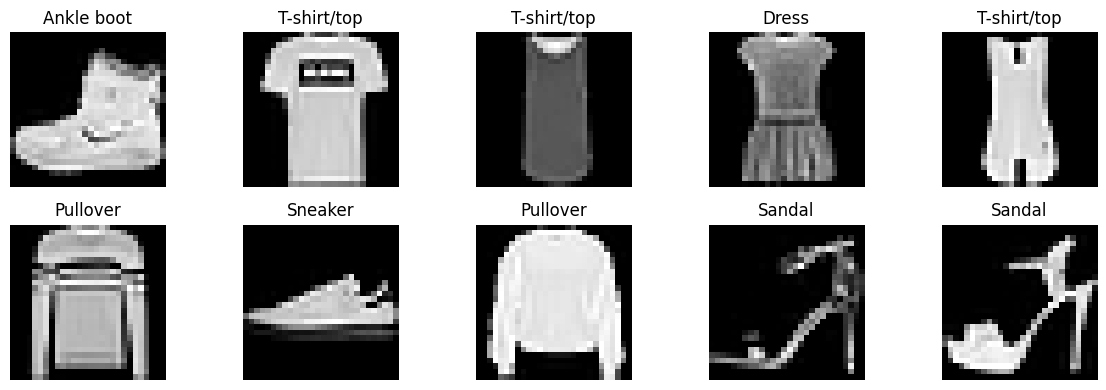

In [17]:
fashion_mnist_class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Visualize the images
## Write your code here
import matplotlib.pyplot as plt

# Number of images to show
num_images = 10

plt.figure(figsize=(12, 4))

for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(fm_X_train[i], cmap='gray')  # images เป็น grayscale
    plt.title(fashion_mnist_class_names[fm_y_train[i]])
    plt.axis('off')

plt.tight_layout()
plt.show()

### **Exercise 2: Preprocessing Images (Flatten and Scale)**

Images are 2D arrays (matrices of pixels) and pixel values are integers from 0-255. For Logistic Regression, we need:
*  **Flattening:** Convert each 28x28 image into a 1D array of 784 features.
*  **Scaling:** Normalize pixel values from [0, 255] to [0, 1].

**Instructions:**

1.   **Flatten:** Use the `.reshape()` method (see [documentation](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.reshape.html)). For `fm_X_train_binary` (shape `(num_samples, 28, 28)`), you want to reshape it to `(num_samples, 28*28)`.
2.  **Scale:** Divide the flattened pixel values by 255.0 to get values between 0 and 1.
3.   **Train Logistic Regression:**
    *   Initialize `LogisticRegression(solver='saga')`. `saga` is a good solver when both number of samples and number of features are large.
    *   Fit the model on your *processed* `fm_X_train_scaled` and `fm_y_train`.
4.   **Make Predictions:** Use `predict()` to make predictions on the *processed* `fm_X_test_scaled`.
5.   **Print Classification Report:** Print `classification_report` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)). What are the accuracy, average precision, average recall, and average f1-score?
6.   **Visualize Misclassifications:**
    *   Find the indices in `fm_X_test_binary` where your model made incorrect predictions (i.e., `fm_y_pred != fm_y_test`).
    *   Select 5 of these misclassified images.
    *   Plot these images (using `plt.imshow`). For each image, print its true label and its predicted label.

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84        55
           1       0.98      0.98      0.98        52
           2       0.72      0.63      0.67        65
           3       0.82      0.87      0.84        46
           4       0.69      0.75      0.72        57
           5       0.85      0.87      0.86        39
           6       0.48      0.53      0.51        47
           7       0.84      0.87      0.85        47
           8       0.98      0.91      0.94        44
           9       0.91      0.88      0.89        48

    accuracy                           0.80       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.80      0.81       500

Number of misclassified samples: 98


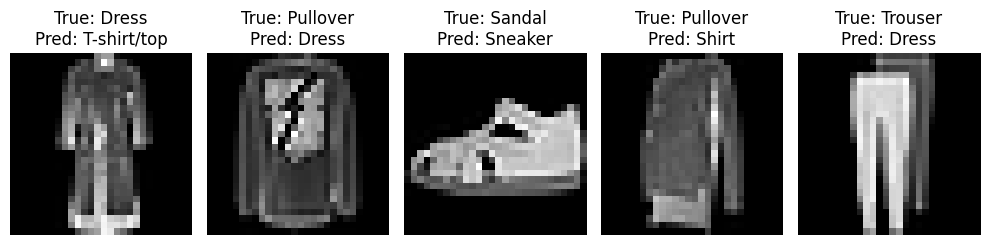

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Flatten
fm_X_train_flat = fm_X_train.reshape(fm_X_train.shape[0], -1)
fm_X_test_flat = fm_X_test.reshape(fm_X_test.shape[0], -1)

# Scale
fm_X_train_scaled = fm_X_train_flat / 255.0
fm_X_test_scaled = fm_X_test_flat / 255.0

# ✅ ลด sample size ให้เหลือเล็กๆ
train_sample_size = 1000
test_sample_size = 500

fm_X_train_sample = fm_X_train_scaled[:train_sample_size]
fm_y_train_sample = fm_y_train[:train_sample_size]
fm_X_test_sample = fm_X_test_scaled[:test_sample_size]
fm_y_test_sample = fm_y_test[:test_sample_size]

# ✅ ใช้ solver='lbfgs' (เร็วกว่า) + max_iter=200
clf = LogisticRegression(solver='lbfgs', max_iter=200)
clf.fit(fm_X_train_sample, fm_y_train_sample)

# Predict
fm_y_pred = clf.predict(fm_X_test_sample)

# Classification report
print("Classification Report:")
print(classification_report(fm_y_test_sample, fm_y_pred))

# Visualize misclassifications
misclassified_idx = np.where(fm_y_pred != fm_y_test_sample)[0]
print(f"Number of misclassified samples: {len(misclassified_idx)}")

# เลือก 5 รูปสุ่มจากที่ผิด (ถ้ามี)
np.random.seed(42)
selected_idx = np.random.choice(misclassified_idx, size=min(5, len(misclassified_idx)), replace=False)

plt.figure(figsize=(10, 3))
for i, idx in enumerate(selected_idx):
    plt.subplot(1, 5, i+1)
    plt.imshow(fm_X_test[:test_sample_size][idx], cmap='gray')
    plt.title(f"True: {fashion_mnist_class_names[fm_y_test_sample[idx]]}\nPred: {fashion_mnist_class_names[fm_y_pred[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Part 3: 20 Newsgroups Dataset - Text Classification

### Load 20 Newsgroups Dataset

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics.

In [20]:
news_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
news_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42)

X_train_news, y_train_news = news_train.data, news_train.target
X_test_news, y_test_news = news_test.data, news_test.target

print(f"Number of training documents: {len(X_train_news)}")
print(f"Number of test documents: {len(X_test_news)}")
print(f"Categories: {news_train.target_names}")

Number of training documents: 11314
Number of test documents: 7532
Categories: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


### Explore Sample Document

In [22]:
# Print the first document and its class
print("First training document:")
print(X_train_news[0])  # ข้อความเต็ม

print("\nClass label (numeric):", y_train_news[0])
print("Class name:", news_train.target_names[y_train_news[0]])

First training document:
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----






Class label (numeric): 7
Class name: rec.autos


### Preprocessing: Text Vectorization Demonstration with `TfidfVectorizer`

$$
\text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)
$$

Where:

$$
\text{TF}(t, d) = \frac{\text{number of word }t\text{ in } d}{\text{number of words in } d} \quad \text{ and } \quad
\text{IDF}(t, D) = \log\left(\frac{\text{total number of documents}}{\text{number of documents that contain word }t}\right).
$$

In [23]:
sample_sentences = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?"
]

vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the sample sentences
sample_vec_output_sparse = vectorizer.fit_transform(sample_sentences)

sample_vec_output_dense = sample_vec_output_sparse.toarray()

print(vectorizer.vocabulary_)
print(vectorizer.get_feature_names_out())
print(sample_vec_output_dense)

{'document': 0, 'second': 1}
['document' 'second']
[[1.         0.        ]
 [0.78722298 0.61666846]
 [0.         0.        ]
 [1.         0.        ]]


### **Exercise 3: Apply TF-IDF Vectorization to Full Dataset**

Now, apply `TfidfVectorizer` to the actual training and testing datasets for the 20 Newsgroups classification task.

**Instructions:**

1.  **Initialize `TfidfVectorizer`:**
    *   Initialize `TfidfVectorizer`. Use `stop_words='english'` to remove common words.
2.  **Fit and Transform Training Data:**
    *   Call `fit_transform()` on `X_train_news` to learn the vocabulary and transform the training text into TF-IDF features. Store the result in `X_train_vec`.
3.  **Transform Test Data:**
    *   Call `transform()` on `X_test_news` using the *already fitted* vectorizer. Store the result in `X_test_vec`. **Crucially, do not call `fit_transform()` on the test data!** This would cause data leakage.
4.  **Initialize Logistic Regression:**
    *   Initialize `LogisticRegression(solver='saga')`. `saga` is a good solver when both number of samples and number of features are large.
5.  **Train the Model:**
    *   Fit the model on your `X_train_vec` and `y_train_news`.
6.  **Make Predictions:**
    *   Make predictions using `predict()` on the `X_test_vec`.
7.  **Evaluate the Model:**
    *   Print `classification_report` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)). What are the accuracy, average precision, average recall, and average f1-score?

In [25]:
# --- YOUR CODE FOR EXERCISE 3 STARTS HERE ---

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 1. Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# 2. Fit and transform training data
X_train_vec = vectorizer.fit_transform(X_train_news)

# 3. Transform test data (only transform, no fit!)
X_test_vec = vectorizer.transform(X_test_news)

# 4. Initialize Logistic Regression
model = LogisticRegression(solver='saga', max_iter=1000)

# 5. Train the model
model.fit(X_train_vec, y_train_news)

# 6. Make predictions
y_pred = model.predict(X_test_vec)

# 7. Evaluate the model
print(classification_report(y_test_news, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76       319
           1       0.71      0.80      0.75       389
           2       0.75      0.76      0.75       394
           3       0.71      0.74      0.72       392
           4       0.80      0.83      0.82       385
           5       0.85      0.75      0.79       395
           6       0.78      0.87      0.82       390
           7       0.90      0.89      0.90       396
           8       0.94      0.95      0.94       398
           9       0.88      0.92      0.90       397
          10       0.94      0.96      0.95       399
          11       0.95      0.91      0.93       396
          12       0.75      0.78      0.76       393
          13       0.88      0.86      0.87       396
          14       0.89      0.91      0.90       394
          15       0.81      0.93      0.86       398
          16       0.75      0.90      0.82       364
          17       0.97    